In [ ]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pandas as pd
from astropy.constants import G, c, M_sun
import astropy.units as u
from scipy.optimize import fsolve

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


# Dark matter

Adimensional 

$$

p' = \frac{p}{m_f^4} \qquad \epsilon' = \frac{\epsilon}{m_f^4}  \qquad  M' =  \frac{M}{a} \qquad R' =  \frac{R}{b}, \qquad a =  \frac{M_p^3}{m_f^2}, \qquad b = \frac{M_p}{m_f^2}
$$

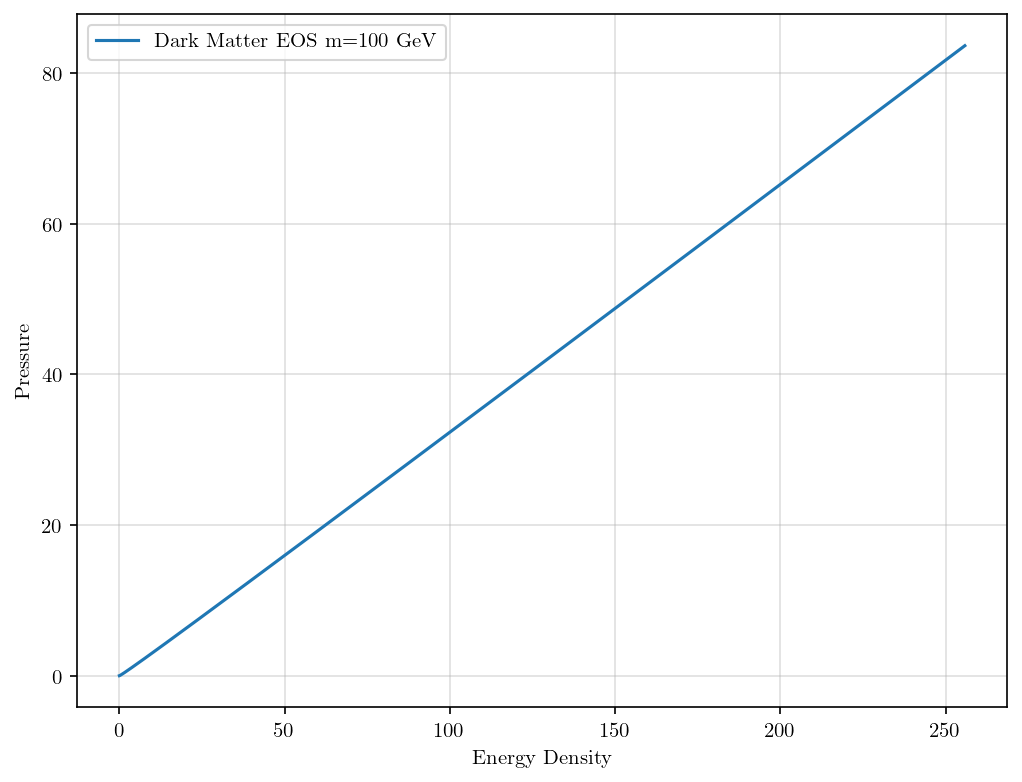

In [ ]:
m_f = 100 *1e3 #MeV

M_p = 1.22 * 1e22 #MeV 


a = M_p**3 / m_f**2
b = M_p / m_f**2

hc = 197.3269804 #MeV fm

def p(k_f):
    z = k_f / m_f
    factor = (m_f**4) / (24 * np.pi**2)
    term1 = (2*z**3-3*z)
    term2 = (1+z**2)**0.5
    term3 = 3 * np.arcsinh(z)
    return factor * (term1*term2 + term3) #Mev^4

def e(k_f):
    z = k_f / m_f
    factor = (m_f**4) / (8 * np.pi**2)
    term1 = (2*z**3 + z)
    term2 = (1+z**2)**0.5
    term3 = np.arcsinh(z)
    return factor * (term1*term2 - term3) #Mev^4

max_kf = int(1e1)
min_kf = 0.001
number_points = int(1e5)
list_kf = np.linspace(min_kf, max_kf, number_points) * m_f  #MeV
list_p = np.array(p(list_kf))/m_f**4 #dimensionless
list_e = np.array(e(list_kf))/m_f**4 #dimensionless

plt.figure(figsize=(8,6), dpi=150)
plt.plot(list_e, list_p, label=f'Dark Matter EOS m={100} GeV')
plt.xlabel('Energy Density')
plt.ylabel('Pressure')
plt.grid()
plt.legend()
plt.show()


plt.show()


Central pressure: 2.327369463223416e-09
Central energy density: 4.482425629706305e-06
Central mass: 1.877594057139724e-23
Final raw pressure: -2.748687216629463e-30
Final pressure: -2.748687216629463e-30


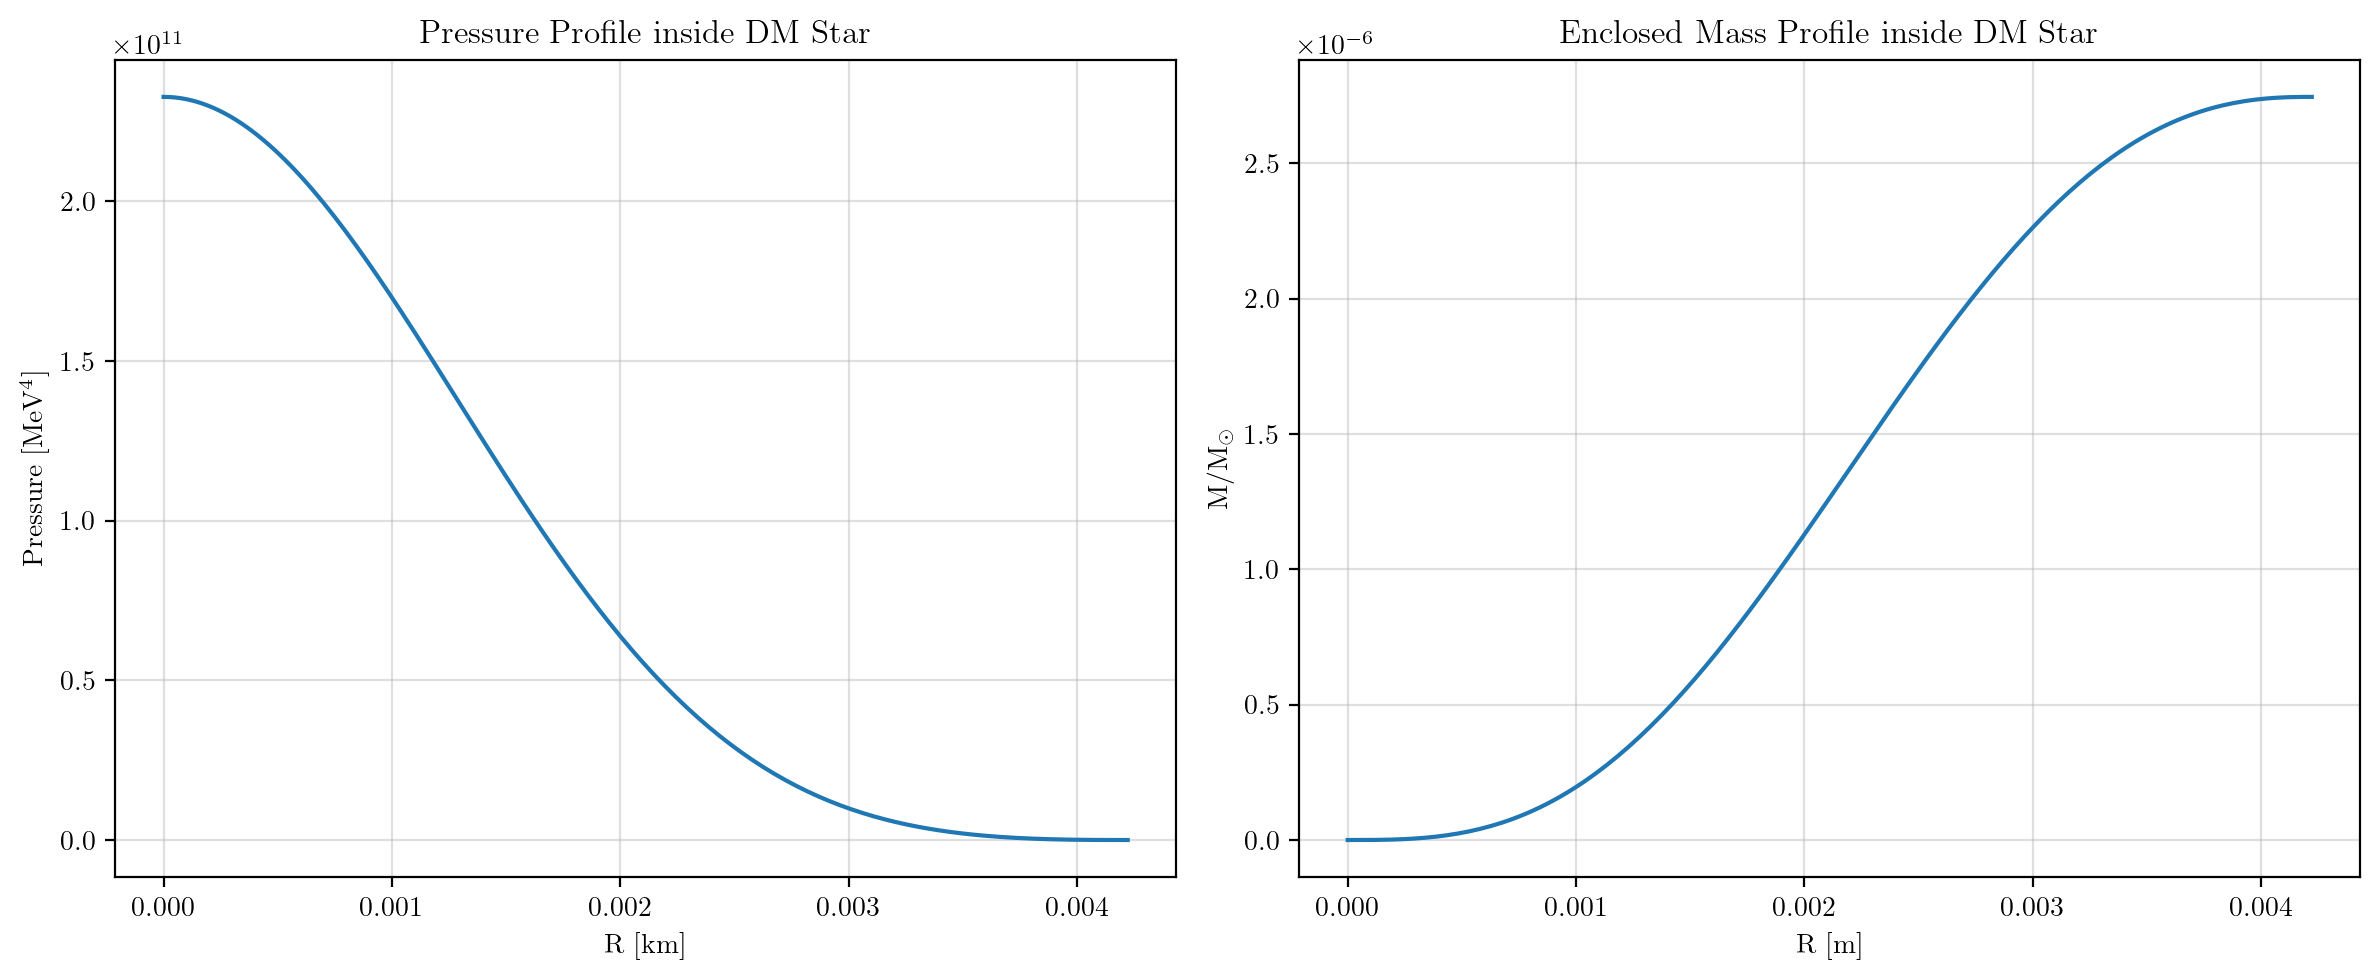

In [ ]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

def ode_TOV(r, x):
    p, M = x

    e = np.interp(p, list_p, list_e)

    if r < 1e-8:
        dpdr = 0.0
        dMdr = 4*np.pi*r**2*e
        return [dpdr, dMdr]

    term1 = (e + p)
    term2 = (M + 4*np.pi*r**3*p)
    term3 = r * (r - 2*M)

    dpdr = - term1 * term2 / term3
    dMdr =  4*np.pi * r**2 * e

    return [dpdr, dMdr]



# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative

central_pressure = list_p[500]
e_central = np.interp(central_pressure, list_p, list_e)
r0 = 1e-6
central_mass = (4/3) * np.pi * (r0**3) * e_central 
x0 = [central_pressure, central_mass]

print("Central pressure:", central_pressure)
print("Central energy density:", e_central)
print("Central mass:", central_mass)
# ----------------------------------------------------
# Solve ODE
# ----------------------------------------------------
sol = solve_ivp(
    ode_TOV,
    (r0, 1e8),     # integrate up to r=1e10 smaller than one km
    x0,
    events=surface_event, 
    max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
)

radius = sol.t
pressure = sol.y[0]
mass = sol.y[1]


final_pressure_raw = sol.y[0, -1]
print("Final raw pressure:", final_pressure_raw)
radius = sol.t
pressure = sol.y[0]
mass = sol.y[1]
final_pressure = sol.y[0, -1]
print("Final pressure:", final_pressure) 

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))
#convert radius to meters:
radius_km = radius * b * 1e-18 * hc #in km

#convert mass to solar masses
solar_mass_in_mev = M_sun.to(u.MeV / c**2).value
mass_in_mev = mass * a
mass_in_solar = mass_in_mev / solar_mass_in_mev

plt.subplot(1,2,1)
plt.plot(radius_km, pressure* (m_f**4))
#plt.plot(radius, pressure)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Pressure Profile inside DM Star")
plt.grid()

plt.subplot(1,2,2)
plt.plot(radius_km, mass_in_solar)
#plt.plot(radius,mass)
plt.xlabel("R [m]")
plt.ylabel("M/M$_\odot$")
plt.title("Enclosed Mass Profile inside DM Star")
plt.grid()

plt.tight_layout()
plt.show()


In [36]:
def solve_TOV(central_energy, x0):

    def ode_TOV(r, x):
        p, M = x

        e = np.interp(p, list_p, list_e)

        if r < 1e-8:
            dpdr = 0.0
            dMdr = 4*np.pi*r**2*e
            return [dpdr, dMdr]

        term1 = (e + p)
        term2 = (M + 4*np.pi*r**3*p)
        term3 = r * (r - 2*M)

        dpdr = - term1 * term2 / term3
        dMdr =  4*np.pi * r**2 * e

        return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 1e20),     # integrate up to r=1e5  corresponds to 
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]


    if P_surface > 1e-10 :
        print("Final pressure is far from 0:", P_surface * (m_f**4), 'MeV^4')
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R_2 = []
list_M_2 = []




for i in range(0, len(list_e),50):
    e, p = list_e[i], list_p[i]
    r0 = 1e-6
    central_mass = (4/3) * np.pi * (r0**3) * e
    x0 = [p, central_mass]


    R_surface, M_surface = solve_TOV(e, x0)


    list_R_2.append(R_surface)
    list_M_2.append(M_surface)

solar_mass_in_mev = M_sun.to(u.MeV / c**2).value
list_R_2 = np.array(list_R_2) * b * 1e-18 * hc  # km
#convert mass to solar masses
list_M_2 = np.array(list_M_2) * a / solar_mass_in_mev

Maximum Mass: 6.255623288366481e-05 M_sun
Minimum Radius: 0.00043442286103716134 km


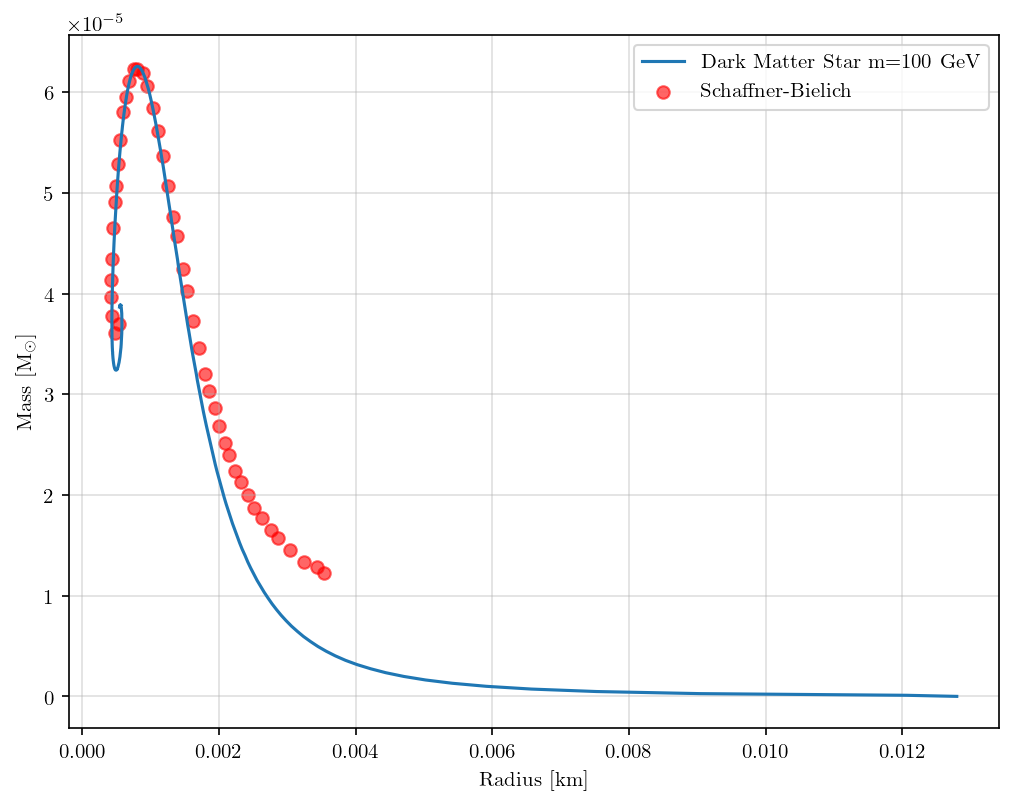

In [39]:
plt.figure(figsize=(8,6), dpi=150)


plt.plot(list_R_2, list_M_2, label=f'Dark Matter Star m={100} GeV')
plt.xlabel('Radius [km]')
plt.ylabel('Mass [M$_\odot$]')
plt.grid()



#open external csv file 
data = pd.read_csv('Data/mass_radius_dm.csv')

plt.scatter(data['x'], data[' y'], color='red', label='Schaffner-Bielich', alpha=0.6)

max_mass_index = np.nanargmax(list_M_2)
print("Maximum Mass:", list_M_2[max_mass_index], "M_sun")
#print("Radius at Maximum Mass:", list_R_2[max_mass_index], "km")

#minimum radius
min_radius_index = np.nanargmin(list_R_2)
print("Minimum Radius:", list_R_2[min_radius_index], "km")
#print("Mass at Minimum Radius:", list_M_2[min_radius_index], "M_sun")
plt.legend()
plt.show()
